# Aperiodic Methods: Time Series

Notes
- When simulating more extreme exponents, take care to update PSD generation settings appropriately
    - Specifically, for Welch's, need to update nperseg pretty drastically to get a PSD that resolves the correct exponent

In [53]:
%matplotlib inline

from scipy.signal import welch

from fooof import FOOOF
from neurodsp import sim, spectral

In [54]:
# Import custom code
import sys; from pathlib import Path
sys.path.append(str(Path('..').resolve()))

from apm.fit import fit_ols

## Helper Functions

In [55]:
from fooof.plts.spectra import plot_spectrum
from fooof.utils import trim_spectrum

def plot_two_psds(fs, ps1, ps2, f_range=None, log_f=False, log_p=False, labels=None):
    
    if f_range:
        _, ps1 = trim_spectrum(fs, ps1, f_range)
        fs, ps2 = trim_spectrum(fs, ps2, f_range)
        
    if log_p:
        ps1 = np.log10(ps1)
        ps2 = np.log10(ps2)

    fig, ax = plt.subplots(figsize=[12, 10])
    
    plot_spectrum(fs, ps1, ax=ax, plt_log=log_f, label=labels[0] if labels else None)#, lw=2.5)
    plot_spectrum(fs, ps2, ax=ax, plt_log=log_f, label=labels[1] if labels else None)#, lw=2.5)

# Simulations

In [56]:
# Simulation settings - used for all simulations
sig_length = 2
s_rate = 500
exp = -2.0

# Oscillation / Burst Settings
rhythm_freq = 20
rhythm_snr = 0.5

## Simulating 1/f Time Series

In [57]:
# Simulate time series data
noise_dat = sim.sim_powerlaw(sig_length, s_rate, exp)

In [58]:
#plt.plot(noise_dat[0:1000])

In [59]:
# Generate a power spectrum
fs, ps = welch(noise_dat, s_rate, nperseg=2*s_rate)

# Fit with FOOOF to check exponent
fm = FOOOF(max_n_peaks=0, verbose=False)
fm.fit(fs, ps)

print('Fit slope :', fm.aperiodic_params_[1])

Fit slope : 1.9617453730911023


## Simulating 1/f Time Series, with Oscilations

In [60]:
# Generate data
sims = {'sim_powerlaw' : {},
        'sim_oscillation' : {'freq' : rhythm_freq}}
osc_dat = sim.sim_combined(sig_length, s_rate, sims)

In [61]:
#plt.plot(osc_dat[0:1000])

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 150 Hz                        
                                 Frequency Resolution is 0.50 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -0.5400, 2.2734                                          
                                                                                                  
                                       2 peaks were found:                                        
          

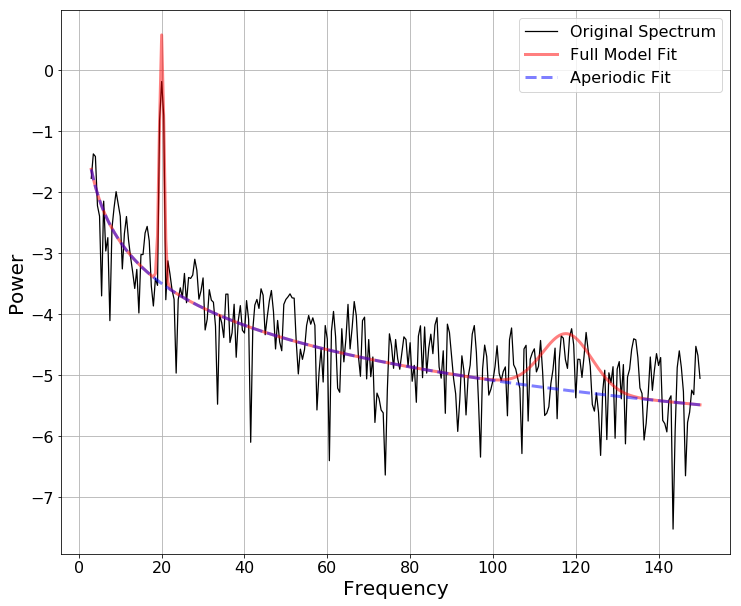

In [62]:
# Generate a power spectrum
fs, ps = welch(osc_dat, s_rate, nperseg=2*s_rate)

# Fit with FOOOF to check exponent
fm = FOOOF(max_n_peaks=2, min_peak_height=1, verbose=False)

fm.report(fs, ps, [3, 150])
#fm.fit(fs, ps, [3, 150])

print('Fit slope :', fm.aperiodic_params_[1])

## Simulating 1/f Time Series, with Bursty Oscillations

In [63]:
# Generate data
sims = {'sim_powerlaw' : {},
        'sim_bursty_oscillation' : {'freq' : rhythm_freq}}
burst_dat = sim.sim_combined(sig_length, s_rate, sims)

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 150 Hz                        
                                 Frequency Resolution is 0.50 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -1.2030, 1.8146                                          
                                                                                                  
                                       2 peaks were found:                                        
          

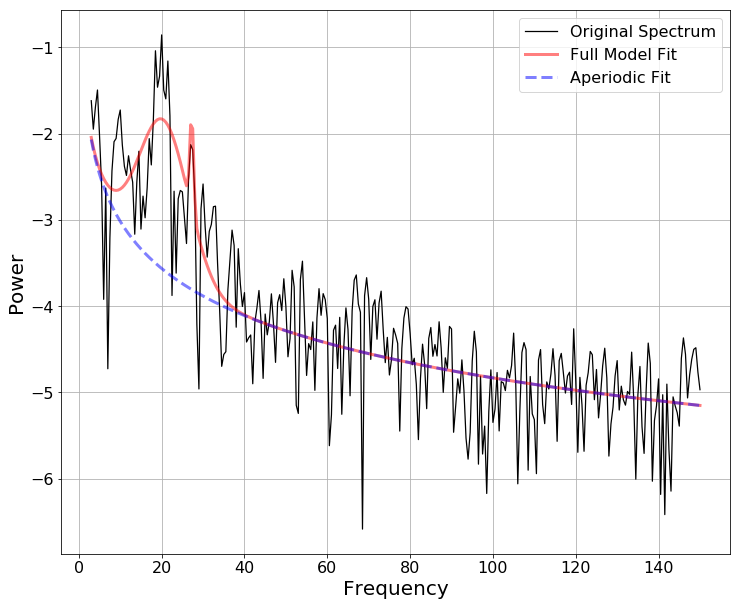

In [64]:
# Generate a power spectrum
fs, ps = welch(burst_dat, s_rate, nperseg=2*s_rate)

# Fit with FOOOF to check exponent
fm = FOOOF(max_n_peaks=2, min_peak_height=1, verbose=False)

fm.report(fs, ps, [3, 150])
#fm.fit(fs, ps, [3, 150])

print('Fit result:', fm.aperiodic_params_[1])

## Method: DFA

In [65]:
ts, dfs, alph = dfa(noise_dat, s_rate)

print(alph)

1.5100996774489486


In [66]:
# From wiki: beta = 2 * alpha -1 
#   So alpha = (beta + 1) / 2
exp_alph = (-exp + 1) / 2
print(exp_alph)

1.5


In [67]:
ts, dfs, alph = dfa(osc_dat, s_rate)

print(alph)

1.066177736783454


## Method: Fractalizer

Notes: seems to crap out entirely with very large oscillations.

In [72]:
ps_frac, ps_mix, fs1 = irasa(osc_dat, s_rate, subsets=15, h=np.linspace(1.1, 1.9, num=20), filter=False)

NameError: name 'irasa' is not defined

In [73]:
fm = FOOOF(max_n_peaks=1, verbose=False)

In [74]:
fm.report(fs1, ps_frac, [3, 100])

NameError: name 'fs1' is not defined

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 100 Hz                        
                                 Frequency Resolution is 0.49 Hz                                  
                                                                                                  
                             Background Parameters (offset, slope):                               
                                          0.1389, 1.9086                                          
                                                                                                  
                                       1 peaks were found:                                        
          

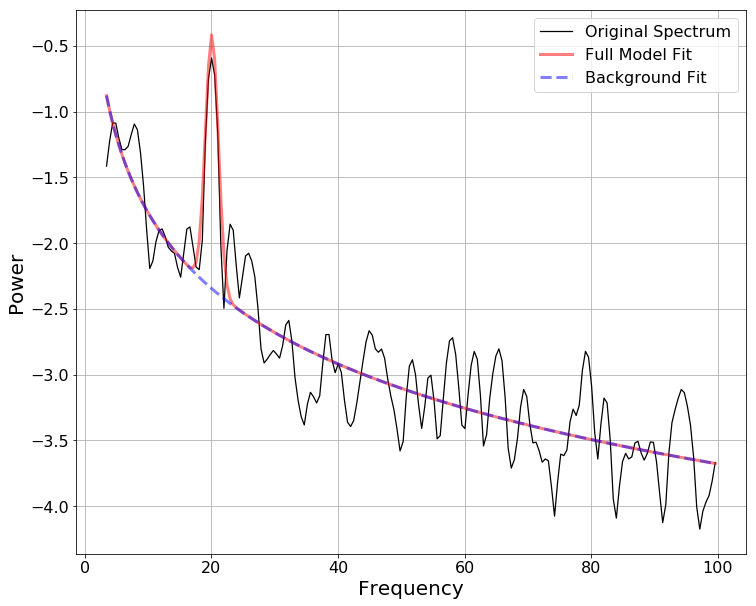

In [807]:
fm.report(fs1, ps_mix, [3, 100])

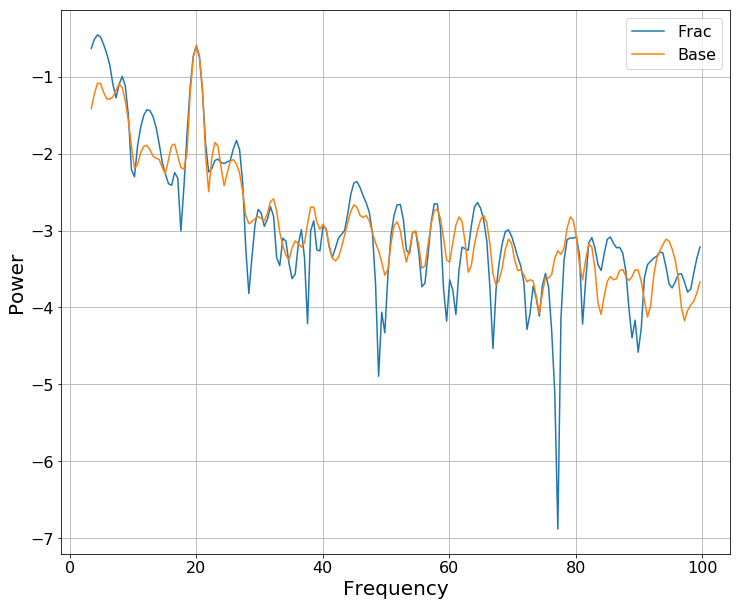

In [808]:
plot_two_psds(fs1, ps_frac, ps_mix, [3, 100], False, True, labels=['Frac', 'Base'])

In [809]:
# Note: skip 0 freq
print('Frac', fsl_ols(fs1[1:], ps_frac[1:]))
print('Mix ', fsl_ols(fs1[1:], ps_mix[1:]))

Frac -1.6311357911
Mix  -1.56054926939


In [674]:
ps, fs2 = irasa2(osc_dat, s_rate, np.asarray(np.linspace(1.1, 1.9, num=17)), 1)

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 3 - 100 Hz                        
                                 Frequency Resolution is 0.49 Hz                                  
                                                                                                  
                             Background Parameters (offset, slope):                               
                                          4.5682, 1.5834                                          
                                                                                                  
                                       1 peaks were found:                                        
          

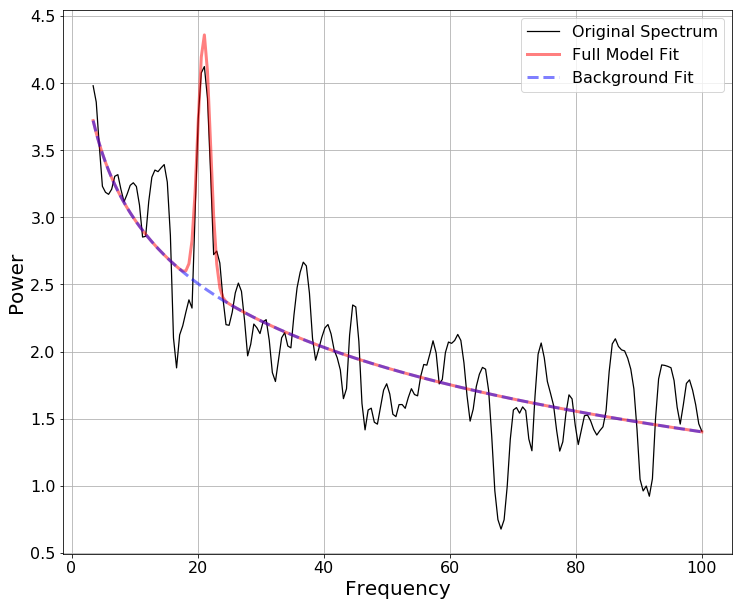

In [675]:
fm.report(fs2, np.squeeze(ps), [3, 100])

## Method: Entropy Measures

In [38]:
from pyentrp import entropy

ModuleNotFoundError: No module named 'pyentrp'

### Permutation Entropy

In [39]:
# Settings
order = 2
delay = 2

In [40]:
pe = entropy.permutation_entropy(noise_dat, order, delay)
print(pe)

pe = entropy.permutation_entropy(osc_dat, order, delay)
print(pe)

NameError: name 'entropy' is not defined

### Sample Entropy

In [41]:
# Settings
sample_length = 4

In [42]:
se = entropy.sample_entropy(noise_dat, sample_length)
print(se)

se = entropy.sample_entropy(osc_dat, sample_length)
print(se)

NameError: name 'entropy' is not defined

## MISC COPIED IN CODE

In [43]:
# Copied from colorednoise

"""Generate colored noise."""

from numpy import concatenate, real, std, abs
from numpy.fft import ifft, fftfreq
from numpy.random import normal

def powerlaw_psd_gaussian(exponent, samples, fmin=0):
    """Gaussian (1/f)**beta noise.
    
    Based on the algorithm in:
    Timmer, J. and Koenig, M.: 
    On generating power law noise. 
    Astron. Astrophys. 300, 707-710 (1995)
    
    Normalised to unit variance
    
    Parameters:
    -----------
    
    exponent : float
        The power-spectrum of the generated noise is proportional to
        
        S(f) = (1 / f)**beta
        flicker / pink noise:   exponent beta = 1
        brown noise:            exponent beta = 2
        
        Furthermore, the autocorrelation decays proportional to lag**-gamma 
        with gamma = 1 - beta for 0 < beta < 1.
        There may be finite-size issues for beta close to one.
    
    samples : int
        number of samples to generate
    
    fmin : float, optional
        Low-frequency cutoff.
        Default: 0 corresponds to original paper. It is not actually
        zero, but 1/samples.
        
    Returns
    -------
    out : array
        The samples.


    Examples:
    ---------

    # generate 1/f noise == pink noise == flicker noise
    >>> import colorednoise as cn
    >>> y = cn.powerlaw_psd_gaussian(1, 5)
    """
    
    # frequencies (we asume a sample rate of one)
    f = fftfreq(samples)
    
    # scaling factor for all frequencies 
    ## though the fft for real signals is symmetric,
    ## the array with the results is not - take neg. half!
    s_scale = abs(concatenate([f[f<0], [f[-1]]]))
    ## low frequency cutoff?!?
    if fmin:
        ix = sum(s_scale>fmin)
        if ix < len(f):
            s_scale[ix:] = s_scale[ix]
    s_scale = s_scale**(-exponent/2.)
    
    # scale random power + phase
    sr = s_scale * normal(size=len(s_scale))
    si = s_scale * normal(size=len(s_scale))
    if not (samples % 2): si[0] = si[0].real

    s = sr + 1J * si
    # this is complicated... because for odd sample numbers,
    ## there is one less positive freq than for even sample numbers
    s = concatenate([s[1-(samples % 2):][::-1], s[:-1].conj()])

    # time series
    y = ifft(s).real

    return y / std(y)